In [14]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE, MDS, Isomap

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
def fcps_reader(name, data_dir='../input/FCPS'):
    points = pd.read_csv(f"{data_dir}/{name}.lrn", sep='\t', comment='%', index_col=0, header=None)
    labels = pd.read_csv(f"{data_dir}/{name}.cls", sep='\t', comment='%', index_col=0, header=None)
    
    points = points.rename(columns= lambda x: f"x{x}")
    labels = labels.rename(columns={labels.columns[0]: 'y'})
    
    return pd.concat([points, labels], axis=1)

In [3]:
atom = fcps_reader('Atom')
atom.head()

,x1,x2,x3,y
0,,,,
1,-4.822490,-50.402170,4.020861,1
2,-44.460120,20.964670,-11.492060,1
3,50.001020,0.780748,9.134460,1
4,-41.699080,-22.310060,16.314120,1
5,4.425242,-4.666664,50.223740,1


In [9]:
atom.y.value_counts()

2    400
1    400
Name: y, dtype: int64

In [4]:
X = atom.iloc[:, :-1].values
y = atom.y

print(X.shape)

pca = PCA(n_components=2).fit_transform(X)
lle = LLE(n_components=2).fit_transform(X)
isomap = Isomap(n_components=2).fit_transform(X)
mds = MDS(n_components=2).fit_transform(X)



(800, 3)


## Auto-encodeur

In [34]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, enbed_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 3),
            nn.ReLU(True),
            nn.Linear(3, 2),
            nn.ReLU(True),
            nn.Linear(2,enbed_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(enbed_size, 2),
            nn.ReLU(True),
            nn.Linear(2, 3),
            nn.ReLU(True),
            nn.Linear(3, input_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
num_epochs = 50

ae = AutoEncoder(3, 2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)

inputs = torch.tensor(X, dtype=torch.float)

for epoch in range(num_epochs):
    # ===================forward=====================
    output = ae(inputs)
    loss = criterion(output, inputs)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [35]:
with torch.no_grad():
    ae_embed = ae.encode(inputs).numpy()

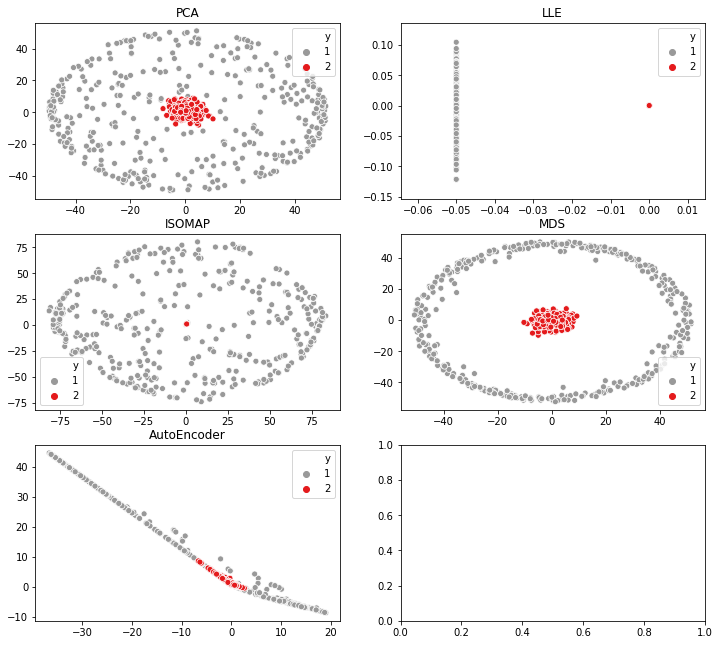

In [36]:
dimred = [("PCA", pca), ("LLE", lle), ("ISOMAP", isomap), ("MDS", mds), ("AutoEncoder", ae_embed)]

fig, axs = plt.subplots(3,2, figsize=(12,11))

for ax, (redname, redvals) in zip(axs.flat, dimred):
    sns.scatterplot(redvals[:, 0], redvals[:, 1], hue=y, ax=ax, palette='Set1_r', legend='full')
    ax.set_title(redname)